### Notebook used to to measure collimation of the telescope using ATCollCam using the CWFS algorithm/package developed by Bo Xin.

#### Now using fork by David Thomas: https://github.com/davidthomas5412/cwfs 

#### This requires that the parameter file for the CWFS algorithm be placed in the cwfs directory structure. 

In [1]:
import numpy as np
#from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
from matplotlib import pyplot as plt
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]


import matplotlib.pyplot as plt
%matplotlib inline
import time

import os
import copy
from pathlib import Path

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')


In [2]:
#Import CWFS package
from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

In [3]:
import numpy as np
import logging
logger = logging.getLogger('calc_CofM_logger')

# declare Centroiding algorithm
def calc_CofM(array, offset=(0,0)):
    # Function takes a a 2d Array and computes the CofM
    
    # offset is the coordinate of the minimum y and x pixel
    
    
    #just make it easier to parse the code below
    shape=array.shape
        
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, shape[0], 1)+ offset[0]
    ones_array_2d=np.ones([shape[1], shape[0]])
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # Can't just use the transpose of the y_index_arr_2d
    # since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, shape[1], 1) + offset[1]
    ones_array_2d=np.ones([shape[0], shape[1]])
    # array will be left to right so need to transpose
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d

    # Calculate the centroid
    y_CofM = np.sum(y_index_arr_2d*array)/np.sum(array)
    x_CofM = np.sum(x_index_arr_2d*array)/np.sum(array)
    
    logger.info('y_CofM is {}'.format(y_CofM))
    logger.info('x_CofM is {}'.format(x_CofM))

    return(y_CofM, x_CofM)

In [4]:
# This is just used to test the CofM algorithm.
def make_circle(yxdims, radius, center=None):
    
    #Creates a circle where the internal pixels equal 1 and the rest are zero
    
    #dims is y,x dimensions
    
    # If center isn't declared then put it at the center of the box
    if center==None:
        center=(yxdims[0]/2, yxdims[1]/2)
    
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, yxdims[1] , 1) - center[1]
    ones_array_2d=np.ones((yxdims[0], yxdims[1]))
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d
    
    # Can't just transpose x-indice array since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, yxdims[0], 1) - center[0]
    ones_array_2d=np.ones((yxdims[1],yxdims[0]))
    # array will be left to right so need to transpose
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # creates an array with a given side, and a circle of radius x and position xy
    r_arr= np.sqrt(y_index_arr_2d**2 + x_index_arr_2d**2)
    
    arr=np.zeros((yxdims[0],yxdims[1]) ,dtype=float)
    
    arr[r_arr < radius] = 1
    return(arr)

In [5]:
# Testing the CofM code
if False:
    center=(1400,750)
    stamp=make_circle((2500,1400), 100, center=center)

    calc_CofM(stamp)

    # Now try with subimage and reference to corner
    side=300
    guess_center = np.array((1550, 610))
    stamp2= stamp[guess_center[0]-side:guess_center[0]+side, 
                  guess_center[1]-side:guess_center[1]+side].copy()
    calc_CofM(stamp2, offset=(guess_center-side))

    if False:
        fig, ax = plt.subplots(figsize=(7,6))
        ax.imshow(stamp, interpolation='none')
        stamp.shape

        fig2, ax2 = plt.subplots(figsize=(7,6))
        ax2.imshow(stamp2, interpolation='none')
        stamp2.shape

### Declare data directories and intra/extra raw file lists

In [6]:
# Declare where data is located and where output will be written, notably the stacked doughnuts
data_folder = Path("/home/saluser/data/20190912")
output_folder = Path("/home/saluser/data/output")

# Extrafocal raw image list from a manually made txt file
file_to_open = data_folder / "HD21161_d05_extra_set.dat"
tmp=file_to_open.read_text()
extra_focal_fnames=tmp.split('\n')
# remove last line as it has just .fits
extra_focal_fnames.remove(extra_focal_fnames[-1])

# Since sometimes i get sent lists with or without .fits!
# this can surely be done in a single line...
if extra_focal_fnames[0].find('fits') == -1:
    for i,f in enumerate(extra_focal_fnames):
        extra_focal_fnames[i]+='.fits'
extra_focal_fnames

['1325440606-HD_21161_extra_z05_20s-0-5.fits',
 '1325440627-HD_21161_extra_z05_20s-1-5.fits',
 '1325440647-HD_21161_extra_z05_20s-2-5.fits',
 '1325440668-HD_21161_extra_z05_20s-3-5.fits',
 '1325440688-HD_21161_extra_z05_20s-4-5.fits']

In [7]:
# Intrafocal raw image list from a manually made txt file
file_to_open = data_folder / "HD21161_d05_intra_set.dat"
tmp=file_to_open.read_text()
intra_focal_fnames=tmp.split('\n')
# remove last line as it has just .fits
intra_focal_fnames.remove(intra_focal_fnames[-1])

# Since sometimes i get sent lists with or without .fits!
# this can surely be done in a single line...
if intra_focal_fnames[0].find('fits') == -1:
    for i,f in enumerate(intra_focal_fnames):
        intra_focal_fnames[i]+='.fits'
intra_focal_fnames

['1325440501-HD_21161_intra_z05_20s-0-5.fits',
 '1325440521-HD_21161_intra_z05_20s-1-5.fits',
 '1325440542-HD_21161_intra_z05_20s-2-5.fits',
 '1325440562-HD_21161_intra_z05_20s-3-5.fits',
 '1325440583-HD_21161_intra_z05_20s-4-5.fits']

In [8]:
# Function to rebin the arrays, not used at the moment but may be
# Example is: 
# binsize=8
#d_binned = rebin(d, [int(d.shape[0]/bin_size), int(d.shape[1]/bin_size)])

def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

## Loop over stack of images, centering to account for jitter then adding to create long-exposure doughnut
### Must verify if building intra or extra!

In [9]:
# Select if you want to make intra or extra-focal image
intra=1 #True
if intra == True:
    focal_fnames = intra_focal_fnames
else:
    focal_fnames = extra_focal_fnames

# get image size and guesstimate the location but just doing a centroid of entire image
img_size=None
with fits.open(data_folder / focal_fnames[0]) as hdul0:
    img_size= (hdul0[0].data).shape
    CofM_estimate = np.array(calc_CofM(hdul0[0].data)) # y,x i

    CofM_estimate=CofM_estimate.astype(int)
    
print('Image size is {}'.format(img_size))
print('CofM estimate is {}'.format(CofM_estimate))

2019-09-13 19:18:32,795 calc_CofM_logger INFO     y_CofM is 432.04858190370015
2019-09-13 19:18:32,797 calc_CofM_logger INFO     x_CofM is 588.4864876251004


Image size is (880, 1164)
CofM estimate is [432 588]


In [10]:
# override of size of image array - watch out for binning!
#img_size=(3520, 4656) # y,x
#img_size=(880, 1164)

# Guess of doughnut location of first image
center_of_ref = (np.round(CofM_estimate[1]), np.round(CofM_estimate[0])) # FIXME: axis mis-match ?!?!
# or override 
center_of_ref=(400, 600)
logger.info('Center of image 0 is set as: {}'.format(center_of_ref))

# Declare sub-array size for centroiding
side=None
side=150
#Declare array for final doughnut
focal_doughnut = None
focal_doughnut = np.zeros((2*side, 2*side), dtype=float)

#reset a bunch of variables because I don't see where the memory issue is.
d=None; d0=None; d1=None

#Loop over all files in list
for i,fname in enumerate(focal_fnames):
    
    with fits.open(data_folder / fname) as hdul0:
        logger.info("Processing file {}".format(fname))
        # data is [y,x]

        #For testing
        #circle = make_circle(img_size, radius=20, center=(900,3080))
        #print('shape of circle: {}'.format(circle.shape))
        
        d0=None        
        raw_frame = None
        #raw_frame = circle
        raw_frame = copy.deepcopy(hdul0[0].data)
        
        # Create subimage
        d0=raw_frame[center_of_ref[0]-side:center_of_ref[0]+side, 
                        center_of_ref[1]-side:center_of_ref[1]+side].copy()
        
        #convert to float
        d0=copy.deepcopy(d0.astype(float))
        logger.debug('shape of d0: {}'.format(d0.shape))

        # subtract median background... which should do nothing to the centroid
        #d1= d0- np.median(d0)
        #d1 = copy.deepcopy(d0)
        #d_full=hdul0[0].data
        
        #boxcar smooth to remove hot pixels
        d = None
        #d = ndimage.median_filter(d1, size=15)
        d = copy.deepcopy(d0)
        
        # Measure centroid (CofM)
        #corner=np.array(center_of_ref)-side
        #d_CofM = calc_CofM(d, corner) # y,x is 3179,923 (add y=20 gives 3160,923)
        #print('Corner coor d_CofM {}'.format(d_CofM))
        
        #now without the reference
        d_CofM=None
        d_CofM = np.array(calc_CofM(d)) # y,x is 3179,923 (add y=20 gives 3160,923)
        logger.debug('No corner correction d_CofM as calculated {}'.format(d_CofM))
    
        yoffset_to_center_of_ref = (d_CofM[0]-side)
        xoffset_to_center_of_ref = (d_CofM[1]-side)
        logger.info('yoffset: {}'.format(yoffset_to_center_of_ref))
        logger.info('xoffset: {}'.format(xoffset_to_center_of_ref))
        
        new_center = None
        new_center = np.array((center_of_ref[0]+yoffset_to_center_of_ref, center_of_ref[1]+xoffset_to_center_of_ref), dtype=int)
        
        logger.debug('new center is: {}'.format(new_center))
        
        # Create new stamp at CofM
        stamp=None
        stamp=raw_frame[new_center[0]-side:new_center[0]+side, 
                        new_center[1]-side:new_center[1]+side].copy()
        
        # Add it to the stack of doughnuts
        focal_doughnut0=copy.deepcopy(focal_doughnut)
        focal_doughnut+=stamp

        # Take the new center and use it as first guess at
        # position for next image
        center_of_ref = copy.deepcopy(new_center)
        
        # Display Imagefor troubleshooting (or finding first center)
        if i >= 3 and False: #7 is problematic
            mag=1
            print('Displaying image {}'.format(fname))
            #plt.rcParams['figure.figsize'] = [7*mag, 6*mag]
            #plt.imshow(d)
            
            fig, ax = plt.subplots(figsize=(7,6))
            ax.imshow(d, interpolation='none')#, extent=[center_of_ref[1]+side,
                                              #       center_of_ref[1]-side, 
                                              #       center_of_ref[0]+side,
                                              #       center_of_ref[0]-side])
            
            fig2, ax2 = plt.subplots(figsize=(7,6))
            ax2.imshow(stamp, interpolation='none')
            
            fig3, ax3 = plt.subplots(figsize=(7,6))
            ax3.imshow(focal_doughnut, interpolation='none')
            
            # show full frame
            #fig, ax = plt.subplots(figsize=(7,6))
            #ax.imshow(d_full, interpolation='none')
            
            break

2019-09-13 19:18:32,997 calc_CofM_logger INFO     Center of image 0 is set as: (400, 600)
2019-09-13 19:18:33,002 calc_CofM_logger INFO     Processing file 1325440501-HD_21161_intra_z05_20s-0-5.fits
2019-09-13 19:18:33,016 calc_CofM_logger INFO     y_CofM is 142.368607996856
2019-09-13 19:18:33,017 calc_CofM_logger INFO     x_CofM is 167.473699125322
2019-09-13 19:18:33,018 calc_CofM_logger INFO     yoffset: -7.631392003143986
2019-09-13 19:18:33,019 calc_CofM_logger INFO     xoffset: 17.473699125322014
2019-09-13 19:18:33,024 calc_CofM_logger INFO     Processing file 1325440521-HD_21161_intra_z05_20s-1-5.fits
2019-09-13 19:18:33,030 calc_CofM_logger INFO     y_CofM is 146.99011574619553
2019-09-13 19:18:33,031 calc_CofM_logger INFO     x_CofM is 157.2547914572391
2019-09-13 19:18:33,033 calc_CofM_logger INFO     yoffset: -3.009884253804472
2019-09-13 19:18:33,033 calc_CofM_logger INFO     xoffset: 7.254791457239094
2019-09-13 19:18:33,037 calc_CofM_logger INFO     Processing file 1325

In [11]:
# view rawframe - sometimes useful to find approximate location
#fig, ax = plt.subplots(figsize=(7,6))
#ax.imshow(raw_frame, interpolation='none')

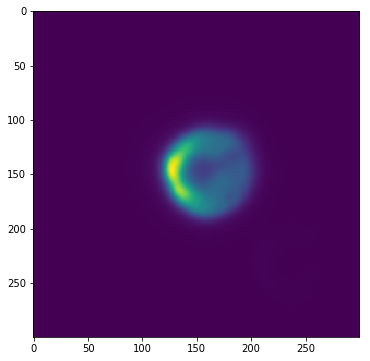

In [12]:
# Show final stacked doughnut
fig4, ax4 = plt.subplots(figsize=(7,6))
ax4.imshow(focal_doughnut, interpolation='none')

In [13]:
#Write fits files (if you want)
# FIXME: need better auto-naming convention!
intra_fname='I1_intra_20190912_HD21161_z05.fits'
extra_fname='I2_extra_20190912_HD21161_z05.fits'

# Set as true to write frames!
if False:
    hdu=None
    hdu = fits.PrimaryHDU(focal_doughnut)
    hdul = fits.HDUList([hdu])
    if intra == True:
        print('writing intra file {}'.format(intra_fname))
        hdul.writeto(output_folder / intra_fname, overwrite=True)
    else:

        print('writing extra file {}'.format(extra_fname))
        hdul.writeto(output_folder / extra_fname, overwrite=True)

In [14]:
# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(output_folder / intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(output_folder / extra_fname))[0].data

In [40]:
#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_exp, fieldXY, Image.INTRA)
I2 = Image(extra_exp, fieldXY, Image.EXTRA)

## Load instrument profile from "/home/saluser/develop/cwfs/data/auxtel"
### Make sure pixelSize and offset are correct for the dataset! 
### You *must* modify the file and not the loaded object!!!

In [41]:
# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))
#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example


Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :20.5 [mm] at the focus
pixelSize should be: 1.44e-05


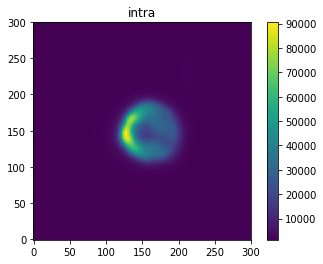

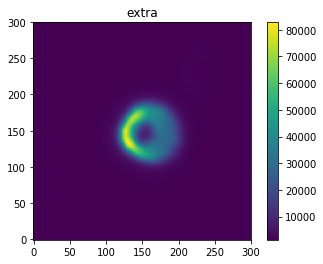

In [42]:
# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')

In [43]:
# Calculate zernikes and wavefront
algo.runIt(inst,I1,I2,'onAxis')

In [47]:
#print zernikes
print(algo.zer4UpNm)

[ -13.3892298     7.94217725  -17.62560122   30.05719529 -196.05331982
   43.08978176   35.59554402   -7.02365575    8.05319775   -3.09493921
    0.25522084    1.52628727   20.62044065   -6.79011205    3.02989717
   -1.2342864     3.46039891    3.43929183    1.64154991]


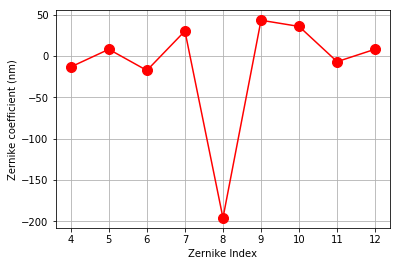

In [55]:
# plot the zernikes
plots.plotZer(algo.zer4UpNm[0:9],'nm')

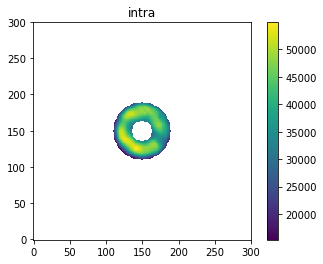

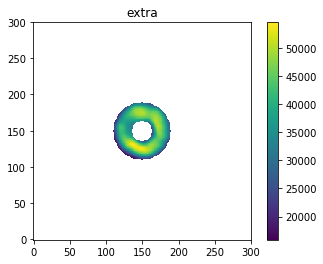

In [56]:
# Plot images with masks to check mapping is correct
# I think these plot residuals
plots.plotImage(I1.image,'intra', mask=algo.pMask) 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra', mask=algo.pMask)

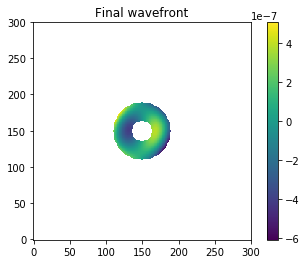

In [57]:
plots.plotImage(algo.Wconverge,'Final wavefront')

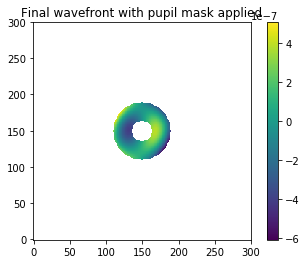

In [58]:
plots.plotImage(algo.Wconverge,'Final wavefront with pupil mask applied', mask=algo.pMask)

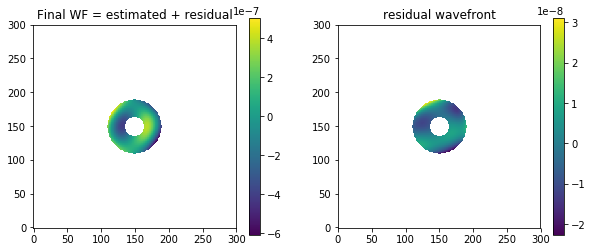

In [59]:
# Look at estimated wavefront and residual of wavefront that is not well fit
nanMask = np.ones(I1.image.shape)
nanMask[I1.pMask==0] = np.nan
fig, ax = plt.subplots(1,2, figsize=[10,4])
img = ax[0].imshow(algo.Wconverge*nanMask, origin='lower')
ax[0].set_title('Final WF = estimated + residual')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(algo.West*nanMask, origin='lower')
ax[1].set_title('residual wavefront')
fig.colorbar(img, ax=ax[1])

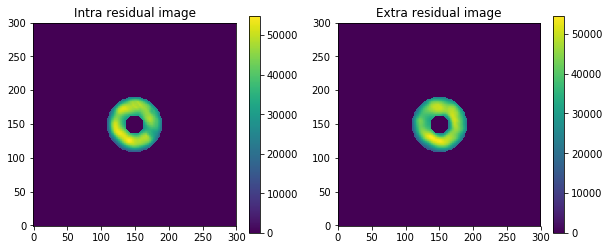

In [60]:
# Plot the residuals at each image - ideally they would be a constant
fig, ax = plt.subplots(1,2, figsize=[10,4])
img = ax[0].imshow(I1.image, origin='lower')
ax[0].set_title('Intra residual image')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(I2.image, origin='lower')
ax[1].set_title('Extra residual image')
fig.colorbar(img, ax=ax[1])

#### Now we do the forward raytrace using our wavefront solutions. The code is simply borrowed from existing cwfs code.

#### We first set up the pupil grid. Oversample means how many ray to trace from each grid point on the pupil.

In [61]:
oversample = 10
projSamples = I1.image0.shape[0]*oversample

luty, lutx = np.mgrid[
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5),
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5)]
lutx = lutx / (projSamples / 2 / inst.sensorFactor)
luty = luty / (projSamples / 2 / inst.sensorFactor)

#### We now trace the rays to the image plane. Lutxp and Lutyp are image coordinates for each (oversampled) ray. showProjection() makes the intensity image. Then, to down sample the image back to original resolution, we want to use the function downResolution() which is defined for the image class.

In [62]:
lutxp, lutyp, J = aperture2image(I1, inst, algo, algo.converge[:,-1], lutx, luty, projSamples, 'paraxial')
show_lutxyp = showProjection(lutxp, lutyp, inst.sensorFactor, projSamples, 1)
I1fit = Image(show_lutxyp, fieldXY, Image.INTRA)
I1fit.downResolution(oversample, I1.image0.shape[0], I1.image0.shape[1])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

#### Now do the same thing for extra focal image

In [ ]:
luty, lutx = np.mgrid[
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5),
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5)]
lutx = lutx / (projSamples / 2 / inst.sensorFactor)
luty = luty / (projSamples / 2 / inst.sensorFactor)

lutxp, lutyp, J = aperture2image(I2, inst, algo, algo.converge[:,-1], lutx, luty, projSamples, 'paraxial')
show_lutxyp = showProjection(lutxp, lutyp, inst.sensorFactor, projSamples, 1)
I2fit = Image(show_lutxyp, fieldXY, Image.EXTRA)
I2fit.downResolution(oversample, I2.image0.shape[0], I2.image0.shape[1])

In [ ]:
#The atmosphere used here is just a random Gaussian smearing. We do not care much about the size at this point
from scipy.ndimage import gaussian_filter

I1fit.image[np.isnan(I1fit.image)]=0
a = gaussian_filter(I1fit.image, sigma=2)

fig, ax = plt.subplots(1,3, figsize=[15,4])
img = ax[0].imshow(I1fit.image, origin='lower')
ax[0].set_title('Forward prediction (no atm) Intra')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(a, origin='lower')
ax[1].set_title('Forward prediction (w atm) Intra')
fig.colorbar(img, ax=ax[1])

img = ax[2].imshow(I1.image0, origin='lower')
ax[2].set_title('Real Image, Intra')
fig.colorbar(img, ax=ax[2])

In [ ]:
I2fit.image[np.isnan(I2fit.image)]=0
b = gaussian_filter(I2fit.image, sigma=2)

fig, ax = plt.subplots(1,3, figsize=[15,4])
img = ax[0].imshow(I2fit.image, origin='lower')
ax[0].set_title('Forward prediction (no atm) Extra')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(b, origin='lower')
ax[1].set_title('Forward prediction (w atm) Extra')
fig.colorbar(img, ax=ax[1])

img = ax[2].imshow(I2.image0, origin='lower')
ax[2].set_title('Real Image, Extra')
fig.colorbar(img, ax=ax[2])

In [ ]:
# Basic math to estimate the expected result (from lab setup)
D=25e-3; wave=632e-9
f_coll=125e-3; 

f_tel=400e-3 # 400mm nominal
pinhole_diam=10e-6

print('Diffraction Limit (f=125mm, D=25mm, wave=632nm) is: {0:3f} [um]'.format(1e6*wave/D*f_coll))
mag=f_tel/f_coll
print('Magnification is f_tel/f_col {}:'.format(mag))
im_size=1e6*mag*pinhole_diam
print('Expected image diameter for {0:3f} diameter pinhole: {1:3f} [um]'.format(pinhole_diam, im_size))
print('80% EE radius in pixels ~{}'.format(im_size/2/10))